In [1]:
import warnings
warnings.filterwarnings("ignore")

import bz2 
import pickle
import _pickle as cPickle
import os
import pandas as pd
from itertools import chain
import numpy as np
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import numpy as np
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import nltk
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import time

# load in cPickle file for Geophysics (OpenAlex ID C8058405)
#discipline = 'C8058405'
# load in cPickle file for Statistics (OpenAlex ID C105795698)
#discipline = 'C105795698'

# load in cPickle file for Oceanography (OpenAlex ID C111368507)
discipline = 'C111368507'

# load in cPickle file for Meteorology (OpenAlex ID C153294291)
discipline = 'C153294291'

Data_Packet = 'OUTPUT_Python_OpenAlex_Citation_and_Abstract_Data_' + discipline + '.pbz2'

f = bz2.BZ2File(Data_Packet, 'rb')
paper_id_year_df = cPickle.load(f)
corpus_dict = cPickle.load(f)
citation_df = cPickle.load(f)

### STEP 1: PREPROCESSING

In [17]:
def reformat(dictionary):
    '''
    Takes the Object 2 dictionary and casts it into a dataframe
    '''
    # remove OpenAlex ID
    field_dictionary = dictionary[1]
    # reformat to list
    field_list = list(map(list, field_dictionary.items()))
    # cast into dataframe and rename columns
    field_df = pd.DataFrame(field_list)
    field_df = field_df.rename(columns = {0: 'work_id', 1: 'terms'})
    
    return field_df

def add_year(field_df, paper_id_year_df):
    '''
    Takes the Object 2 dataframe and merges it with corresponding publication years from Object 1
    '''
    # merge the two dataframes
    merged = pd.merge(field_df, paper_id_year_df, on ='work_id', how ='inner')
    # reorder columns
    columns = merged.columns.tolist()
    columns = columns[-1:] + columns[-2:-1] + columns[:-2]
    reordered = merged[columns]
    
    return reordered

def lowercase(dataframe, column):
    '''
    takes a dataframe and lowercases everything within a specified column (column contents must be in a list of strings)
    '''
    dataframe[column] = dataframe[column].apply(lambda lst: [word.lower() for word in lst])
    return dataframe

corpus = lowercase(add_year(reformat(next(iter(corpus_dict.items()))), paper_id_year_df), 'terms')
corpus = corpus[['publication_year', 'terms']].set_index('publication_year').sort_values(by=['publication_year'])

# remove rows with empty lists
corpus = corpus[corpus['terms'].map(lambda d: len(d)) > 0]

# reformat row as strings
corpus = corpus.astype({'terms':'string'})

regex = r'[^a-z\s]'

def tokenize(text):
    '''
    Cleans, tokenizes + stems Pandas series of strings    
    Returns pandas series of lists of tokens (casted into dataframe)
    '''
    # Clean text with regex
    clean = text.str.lower().str.replace(regex, '', regex=True)

    # Anonymous tokenizer + stemmer functions
    stop = nltk.corpus.stopwords.words('english')
    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stop]
    stemmer = lambda tokens: [SnowballStemmer('english').stem(token) for token in tokens]

    # Tokenize and stem clean text
    tokens = clean.apply(tokenize)
    stemmed_tokens = tokens.apply(stemmer)
    
    # return series of lists of tokens as dataframe
    return stemmed_tokens.to_frame()

In [18]:
stemmed_tokens = tokenize(corpus['terms'])
stemmed_tokens.reset_index(inplace=True)

# aggregate documents per year and concatenate the list(s) of words
aggregated = stemmed_tokens.groupby('publication_year', as_index=False)['terms'].agg(lambda x: list(x))

# get number of documents per year
aggregated['documents'] = [len(i) for i in aggregated['terms']]

# convert publication_year from string to integer
aggregated['publication_year'] = pd.to_numeric(aggregated['publication_year'])

print('Full corpus for Geophysics (OpenAlex ID C8058405), aggregated by year and with each document as list wthin list')
display(aggregated.tail())

print('\nFull corpus for Geophysics (OpenAlex ID C8058405), for topic modeling, preserving individual documents as rows')
stemmed_tokens['publication_year'] = pd.to_numeric(stemmed_tokens['publication_year'])
stemmed_tokens.tail()

Full corpus for Geophysics (OpenAlex ID C8058405), aggregated by year and with each document as list wthin list


,publication_year,terms,documents
80,2018,"[[deposit, sea, seawat, studi, wet, deposit, s...",2602
81,2019,"[[aerob, anoxygen, marin, aerob, function, gro...",3146
82,2020,"[[measur, restratifi, detail, measur, restrati...",5441
83,2021,"[[oil, snow, marin, oil, snow, sediment, marin...",4547
84,2022,"[[comparison, larg], [sandi, beach, popul, pat...",2353



Full corpus for Geophysics (OpenAlex ID C8058405), for topic modeling, preserving individual documents as rows


,publication_year,terms
37243,2022,"[sea, fog, sea, breez, frequenc, sea, occurr, ..."
37244,2022,"[nuisanc, flood, flood, event, highest, flood,..."
37245,2022,"[surfac, temperatur, sea, surfac, spring, sea,..."
37246,2022,"[breed, coloni, fish, breed, continu, fish, co..."
37247,2022,"[rjaxksa, dk, iwokzuqeku, yxkusvuqdjk, djus, i..."


### STEP 2: TOPIC MODELING

In [19]:
def prepare_data(tokens):
    '''
    Prepares Pandas series of lists of tokens for use within a Gensim topic model
    
    Returns an id2word dictionary + bag of words corpus
    '''
    # initialize series of tokens as Gensim Dictionary for further processing
    dictionary = corpora.Dictionary([i for i in tokens])

    # convert dictionary into bag of words format: list of (token_id, token_count) tuples
    bow_corpus = [dictionary.doc2bow(text) for text in tokens]
    
    return dictionary, bow_corpus

def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    '''
    Computes Coherence values for LDA models with differing numbers of topics.
    
    Returns list of models along with their respective coherence values (pick
    models with the highest coherence)
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20,
                                                 iterations=400)
        model_list.append(model)
        coherence_model = models.coherencemodel.CoherenceModel(model=model,  corpus=corpus, dictionary=dictionary,
                                                               coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# file:///C:/Users/Silvan%20Baier/Documents/UChicago/MACS%2030124%20Computational%20Analysis%20of%20Social%20Processes/08_TM_Demo/08_TM_Demo.html

In [39]:
years = [*set(stemmed_tokens['publication_year'].values.tolist())]

In [21]:
coherence_list = []
topics_list = []

start_time = time.time()

for year in years:
    
    print(year)

    sample = stemmed_tokens[stemmed_tokens['publication_year'] == year]
    
    # prepare data for topic modeling with Gensim
    dictionary, bow_corpus = prepare_data(sample['terms'])
    
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=sample,
                                                            start=1, limit=100, step=1)
    
    #print('coherence_values:', coherence_values)
    coherence_list.append(max(coherence_values))
    #topics_list.append(initial_start + step * coherence.index(min(coherence_values)))
    topics_list.append(1 + coherence_values.index(max(coherence_values)))
    
print(years)
print(coherence_list)
print(topics_list)

end_time = time.time()
print('Elapsed Time:', str(end_time - start_time), 'seconds, or', str((end_time - start_time)/60), 'minutes')

1807
1860
1862
1869
1879
1883
1887
1894
1898
1899
1912
1927
1939
1940
1943
1947
1948
1949
1954
1956
1957
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


KeyboardInterrupt: 

In [45]:
# shorten years because I had to interrupt the models after 2014
shortened_years = years[:-9]

### STEP 3: VISUALIZE RESULTS

In [46]:
# PLOT NUMBER OF DOCUMENTS, NUMBER OF TOPICS, AND COHERENCE SCORE OVER TIME

# convert lists to dataframe and fill empty years
tm_df = pd.DataFrame({'year': shortened_years, 'coherence score': coherence_list, 'number of topics': topics_list})

index = list(range(min(shortened_years), max(shortened_years) + 1))

tm_df_complete = pd.DataFrame(np.nan, index=index, columns=['coherence score', 'number of topics'])

tm_df_complete = tm_df_complete.fillna(tm_df.set_index('year'))

tm_df_complete.reset_index(inplace=True)
tm_df_complete = tm_df_complete.rename(columns = {'index':'year'})

# save dataframe
tm_df_complete.to_csv('tm_df_iteration_1_oceanography_100_iterations.csv')

tm_df_complete

,year,coherence score,number of topics
0,1807,1.000089e-12,37.0
1,1808,NaN,NaN
2,1809,NaN,NaN
3,1810,NaN,NaN
4,1811,NaN,NaN
...,...,...,...
202,2009,-4.851911e+00,1.0
203,2010,-4.735455e+00,2.0
204,2011,-4.295466e+00,1.0
205,2012,-6.673533e+00,3.0


In [2]:
import seaborn as sns

In [3]:
# read in results from past iteration
df = pd.read_csv('tm_df_iteration_1_statistics.csv', index_col=0)

tm_df_complete = df[:-2]

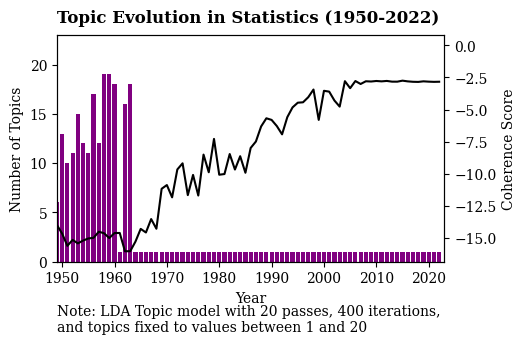

In [4]:
year_array = tm_df_complete['year'].to_numpy()
coherence_array = tm_df_complete['coherence score'].to_numpy()
topics_array = tm_df_complete['number of topics'].to_numpy()

# subset arrays for regression line
year_array_19502022 = np.delete(year_array, np.where(year_array <= 1950))
topics_array_19502022 = topics_array.tolist()[-len(year_array_19502022):]

fig, ax = plt.subplots(figsize = [5, 3], dpi = 100, facecolor = "white", edgecolor = "white")

ax.set_xlabel('Year', size = 10, **{'fontname':'serif'})
ax.set_ylabel('Number of Topics', size = 10, **{'fontname':'serif'})
ax.set_title('Topic Evolution in Statistics (1950-2022)', fontweight = 'bold', size = 12, loc='left', y=1.02,
             **{'fontname':'serif'})

ax.set_ylim([0, 23])

ax.bar(year_array, topics_array, color='purple')

#sns.regplot(x=year_array_19502022, y=topics_array_19502022, scatter=False, ci=False, lowess=True,
#            line_kws={'color':'blue', 'linewidth':1.5})

ax2 = ax.twinx()
ax2.set_ylabel('Coherence Score', size = 10, **{'fontname':'serif'})
ax2.plot(year_array, coherence_array, 'black', linewidth = 1.5)

plt.xlim([1949, 2023])

for tick in ax.get_xticklabels():
    tick.set_fontname('serif')
for tick in ax.get_yticklabels():
    tick.set_fontname('serif')
for tick in ax2.get_yticklabels():
    tick.set_fontname('serif')

plt.annotate(('Note: LDA Topic model with 20 passes, 400 iterations,\nand topics fixed to values between 1 and 20'),
             (0,0), (0, -50), xycoords = 'axes fraction', textcoords = 'offset points', size = 10, **{'fontname':'serif'})

plt.show()

In [6]:
fig.savefig('topic_evolution_statistics_20_iterations.png', bbox_inches='tight', dpi=800)

In [7]:
# read in results from past iteration
df = pd.read_csv('tm_df_iteration_1_oceanography_100_iterations.csv', index_col=0)

tm_df_complete = df

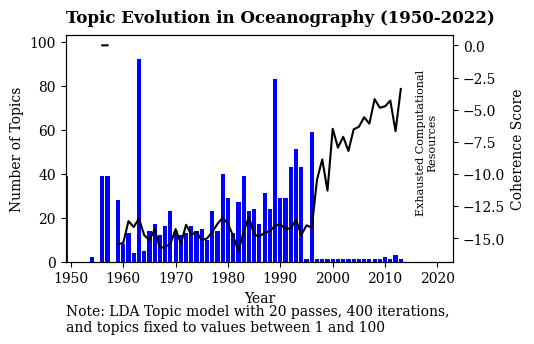

In [8]:
year_array = tm_df_complete['year'].to_numpy()
coherence_array = tm_df_complete['coherence score'].to_numpy()
topics_array = tm_df_complete['number of topics'].to_numpy()

# subset arrays for regression line
year_array_19502022 = np.delete(year_array, np.where(year_array <= 1950))
topics_array_19502022 = topics_array.tolist()[-len(year_array_19502022):]

fig, ax = plt.subplots(figsize = [5, 3], dpi = 100, facecolor = "white", edgecolor = "white")

ax.set_xlabel('Year', size = 10, **{'fontname':'serif'})
ax.set_ylabel('Number of Topics', size = 10, **{'fontname':'serif'})
ax.set_title('Topic Evolution in Oceanography (1950-2022)', fontweight = 'bold', size = 12, loc='left', y=1.02,
             **{'fontname':'serif'})

ax.set_ylim([0, 103])

ax.bar(year_array, topics_array, color='blue')

#sns.regplot(x=year_array_19502022, y=topics_array_19502022, scatter=False, ci=False, lowess=True,
#            line_kws={'color':'blue', 'linewidth':1.5})

ax2 = ax.twinx()
ax2.set_ylabel('Coherence Score', size = 10, **{'fontname':'serif'})
ax2.plot(year_array, coherence_array, 'black', linewidth = 1.5)

plt.xlim([1949, 2023])

for tick in ax.get_xticklabels():
    tick.set_fontname('serif')
for tick in ax.get_yticklabels():
    tick.set_fontname('serif')
for tick in ax2.get_yticklabels():
    tick.set_fontname('serif')

plt.annotate(('Note: LDA Topic model with 20 passes, 400 iterations,\nand topics fixed to values between 1 and 100'),
             (0,0), (0, -50), xycoords = 'axes fraction', textcoords = 'offset points', size = 10, **{'fontname':'serif'})

plt.text(2018, -7.5, 'Exhausted Computational\nResources', fontsize = 8, rotation  = 90, **{'fontname':'serif'}, ha='center', va='center')

plt.show()

In [9]:
fig.savefig('topic_evolution_oceanography_100_iterations_condensed.png', bbox_inches='tight', dpi=800)